In [131]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GATConv
# from torch_geometric.transforms import NormalizeFeatures

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

### 加载Cora数据集

In [132]:
dataset = Planetoid(root='data/Planetoid', name='Cora') # transform=NormalizeFeatures
print(f"datasets:{dataset}")
print(f"num of graphs:{len(dataset)}")
print(f"num of classes: {dataset.num_classes}")

datasets:Cora()
num of graphs:1
num of classes: 7


In [133]:
data = dataset[0]
print(data)
print(f"num of nodes: {data.num_nodes}")
print(f"num of node_features: {data.num_node_features}")
print(f"num of edges: {data.num_edges}")
print(f"num of training node: {data.train_mask.sum()}")
print(f"training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}")

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
num of nodes: 2708
num of node_features: 1433
num of edges: 10556
num of training node: 140
training node label rate: 0.05


In [134]:
# def visualize(h, color):
#     z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy()) 
#     plt.figure(figsize=(10,10))
#     plt.xticks([])
#     plt.yticks([])

#     plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
#     plt.show()
    
# visualize(data.x, color=data.y)

### MLP

In [135]:
LEARNING_RATE = 0.1
WEIGHT_DACAY = 5e-4
EPOCHS = 200

In [136]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(1)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        # x = data.x
        x = self.lin1(x)
        x = F.relu(x) # ReLU激活函数
        x = F.dropout(x, p=0.6, training=self.training) # 训练时随机丢弃60%的元素
        x = self.lin2(x)
        return x

In [137]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # CrossEntropyLoss结合有LogSoftmax和NLLLoss两个类
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DACAY)

In [138]:
def train():
      model.train()
      optimizer.zero_grad() # 重置梯度
      out = model(data.x)   # 输入初始节点表征：torch.Size([2708, 1433])
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward() # 反向传播，计算梯度
      optimizer.step() # 根据梯度更新模型参数
      return loss

In [139]:
def test():
      model.eval() # 评估模式，不dropout
      out = model(data.x)
      pred = out.argmax(dim=1) # 选择概率最大的作为预测类别
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc, out

In [140]:
# 训练
for epoch in range(EPOCHS):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

# 测试与可视化
test_acc, out = test()
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 000, Loss: 1.9523
Epoch: 001, Loss: 1.7555
Epoch: 002, Loss: 1.3987
Epoch: 003, Loss: 1.2105
Epoch: 004, Loss: 0.9572
Epoch: 005, Loss: 1.0474
Epoch: 006, Loss: 0.7376
Epoch: 007, Loss: 0.9728
Epoch: 008, Loss: 0.7232
Epoch: 009, Loss: 0.8053
Epoch: 010, Loss: 0.7718
Epoch: 011, Loss: 0.7328
Epoch: 012, Loss: 0.7367
Epoch: 013, Loss: 0.6851
Epoch: 014, Loss: 0.6220
Epoch: 015, Loss: 0.7024
Epoch: 016, Loss: 0.5960
Epoch: 017, Loss: 0.7491
Epoch: 018, Loss: 0.7044
Epoch: 019, Loss: 0.7084
Epoch: 020, Loss: 0.5809
Epoch: 021, Loss: 0.7245
Epoch: 022, Loss: 0.7307
Epoch: 023, Loss: 0.5345
Epoch: 024, Loss: 0.5838
Epoch: 025, Loss: 0.6066
Epoch: 026, Loss: 0.7383
Epoch: 027, Loss: 0.6354
Epoch: 028, Loss: 0.5276
Epoch: 029, Loss: 0.5799
Epoch: 030, Loss: 0.6097
Epoch: 031, Loss: 0.6918
Epoch: 032, Loss: 0.6489
Epoch: 033, Loss: 0.6793
Epoch: 034, Loss: 0.7180
Epoch: 035, Loss: 0.5817
Epoch: 036, Loss: 0.6939
Epoch: 037, Loss: 0.6051
Epoch: 038, Loss: 0.6908
Epoch: 039, Loss: 0.6749


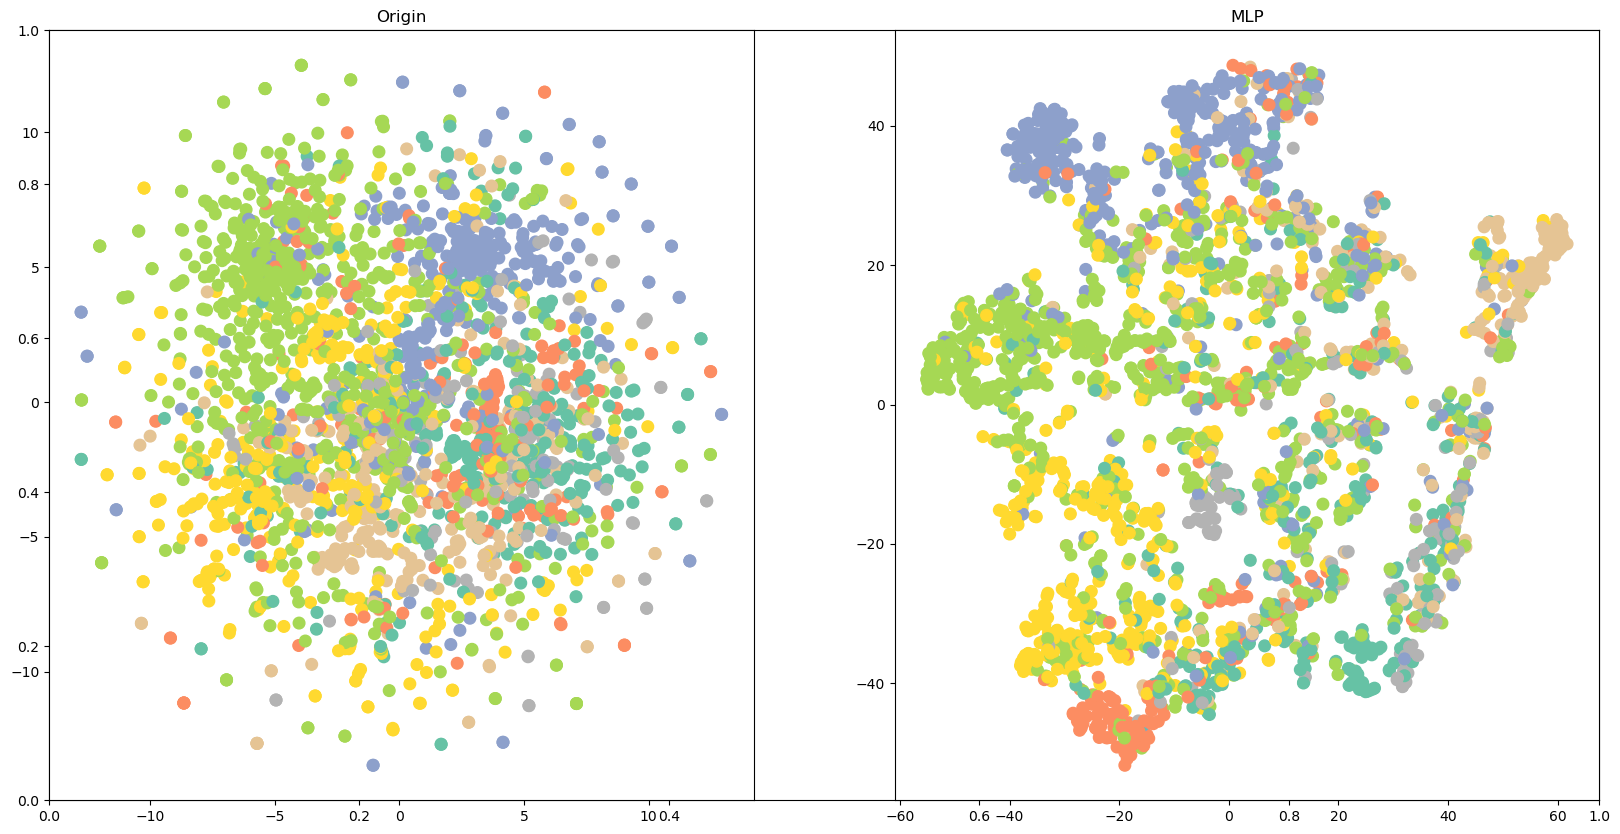

In [141]:
# 分类结果可视化
def visualize_two(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    
fig, ax1 = plt.subplots(figsize=(20, 10))
plt.subplot(1, 2, 1)
visualize_two(data.x, color=data.y) # 原始数据的可视化
plt.title("Origin")
plt.subplot(1, 2, 2)
visualize_two(out, color=data.y) # MLP分类结果可视化
plt.title("MLP")
plt.show()

### GCN

In [142]:
# HIDDEN_CHANNELS = 16
LEARNING_RATE = 0.1
WEIGHT_DACAY = 5e-4
EPOCHS = 200

In [143]:
class GCN(torch.nn.Module):
    def __init__(self,hidden_channels=16):
        super(GCN, self).__init__()
        torch.manual_seed(1)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x) # ReLU激活函数
        x = F.dropout(x, p=0.6, training=self.training) # 训练时随机丢弃60%的元素
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [144]:
# 初始化模型、优化器和损失函数
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DACAY)

In [145]:
# 训练模型
def train():
    model.train()
    optimizer.zero_grad() # 重置梯度
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward() # 反向传播，计算梯度
    optimizer.step() # 根据梯度更新模型参数
    return loss.item()

In [146]:
# 测试模型
def test():
    model.eval() # 评估模式，不dropout
    logits = model(data)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [147]:
# 训练和测试循环
for epoch in range(EPOCHS):
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

# 输出最终的测试准确率
print(f'Final Test Accuracy: {test_acc:.4f}')

Epoch: 000, Loss: 1.9421, Train Acc: 0.4429, Val Acc: 0.2360, Test Acc: 0.2780
Epoch: 001, Loss: 1.5577, Train Acc: 0.8929, Val Acc: 0.5660, Test Acc: 0.6060
Epoch: 002, Loss: 0.8596, Train Acc: 0.9429, Val Acc: 0.7300, Test Acc: 0.7740
Epoch: 003, Loss: 0.5984, Train Acc: 0.9857, Val Acc: 0.7440, Test Acc: 0.7860
Epoch: 004, Loss: 0.3119, Train Acc: 0.9857, Val Acc: 0.7400, Test Acc: 0.7700
Epoch: 005, Loss: 0.2690, Train Acc: 0.9857, Val Acc: 0.7700, Test Acc: 0.7970
Epoch: 006, Loss: 0.2227, Train Acc: 0.9857, Val Acc: 0.7800, Test Acc: 0.8180
Epoch: 007, Loss: 0.1527, Train Acc: 0.9929, Val Acc: 0.7680, Test Acc: 0.8120
Epoch: 008, Loss: 0.0823, Train Acc: 0.9929, Val Acc: 0.7580, Test Acc: 0.7970
Epoch: 009, Loss: 0.0896, Train Acc: 1.0000, Val Acc: 0.7360, Test Acc: 0.7740
Epoch: 010, Loss: 0.0767, Train Acc: 1.0000, Val Acc: 0.7320, Test Acc: 0.7670
Epoch: 011, Loss: 0.1046, Train Acc: 1.0000, Val Acc: 0.7520, Test Acc: 0.7670
Epoch: 012, Loss: 0.0718, Train Acc: 0.9929, Val Acc

<Figure size 640x480 with 0 Axes>

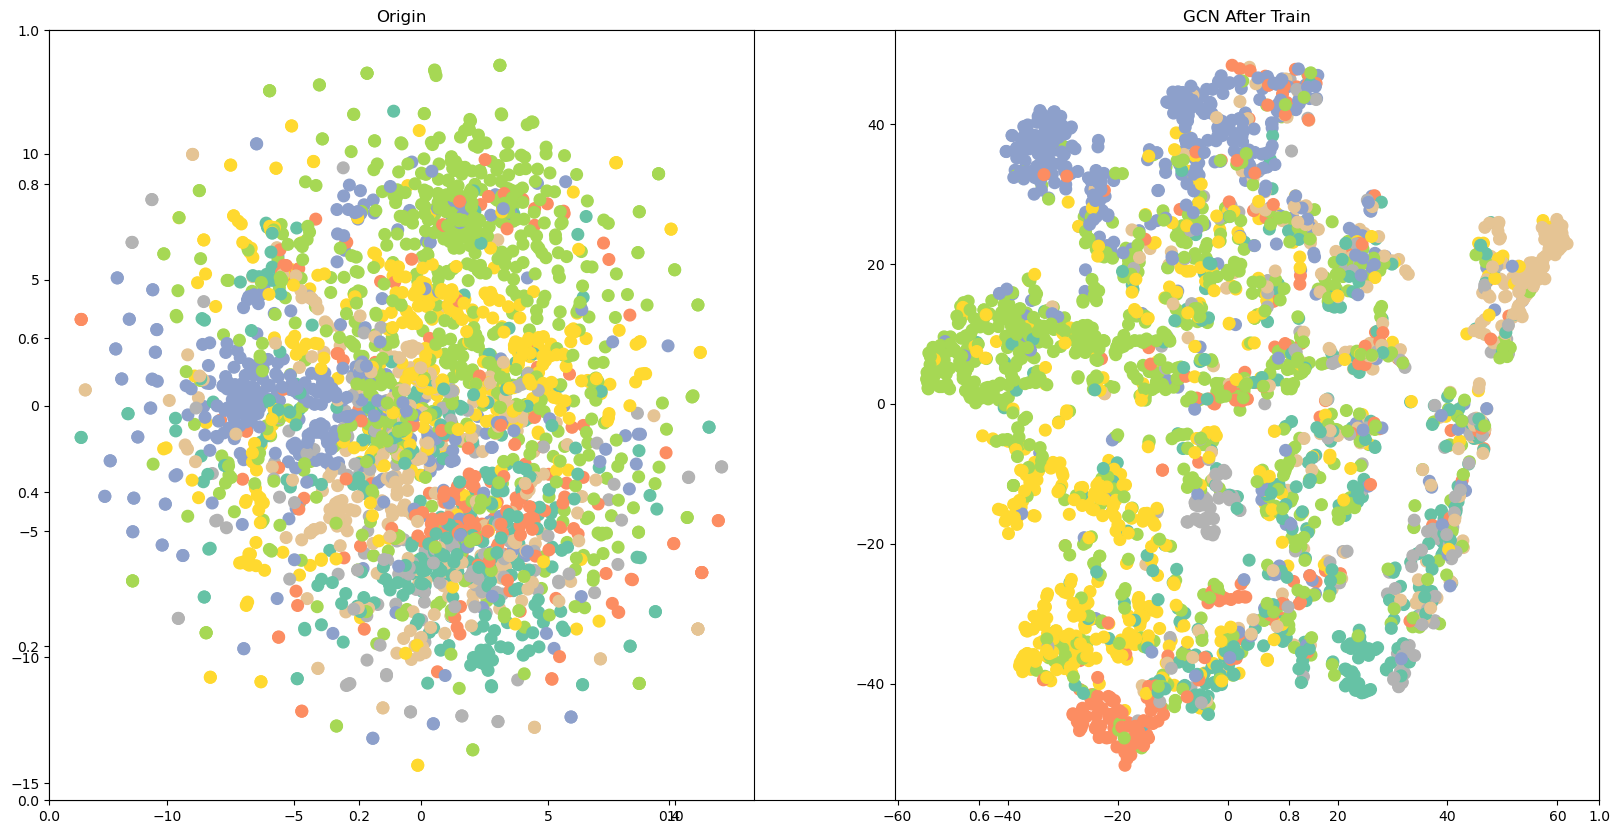

In [149]:
# 分类结果可视化
plt.figure(2)
fig, ax1 = plt.subplots(figsize=(20, 10))
plt.subplot(1, 2, 1)
visualize_two(data.x, color=data.y) # 原始数据的可视化
plt.title("Origin")
plt.subplot(1, 2, 2)
visualize_two(out, color=data.y) # GCN分类结果可视化
plt.title("GCN After Train")
plt.show()

### GAT

In [150]:
LEARNING_RATE = 0.1
WEIGHT_DACAY = 5e-4
EPOCHS = 200

In [151]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT,self).__init__()
        torch.manual_seed(1)
        self.conv1 = GATConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, dataset.num_classes)  
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [152]:
# 初始化模型、优化器和损失函数
model = GAT(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DACAY)

In [153]:
# 训练模型
def train():
    model.train()
    optimizer.zero_grad() # 重置梯度
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward() # 反向传播，计算梯度
    optimizer.step() # 根据梯度更新模型参数
    return loss.item()

In [154]:
# 测试模型
def test():
    model.eval() # 评估模式，不dropout
    logits, accs = model(data), []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [155]:
# 训练和测试循环
for epoch in range(EPOCHS):
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

# 输出最终的测试准确率
print(f'Final Test Accuracy: {test_acc:.4f}')

Epoch: 000, Loss: 1.9492, Train Acc: 0.7643, Val Acc: 0.5620, Test Acc: 0.5840
Epoch: 001, Loss: 1.3309, Train Acc: 0.9000, Val Acc: 0.6880, Test Acc: 0.7190
Epoch: 002, Loss: 0.7409, Train Acc: 0.9214, Val Acc: 0.7500, Test Acc: 0.7580
Epoch: 003, Loss: 0.5668, Train Acc: 0.9571, Val Acc: 0.7320, Test Acc: 0.7510
Epoch: 004, Loss: 0.5510, Train Acc: 0.9071, Val Acc: 0.6660, Test Acc: 0.6760
Epoch: 005, Loss: 0.6223, Train Acc: 0.9214, Val Acc: 0.6140, Test Acc: 0.6300
Epoch: 006, Loss: 0.4934, Train Acc: 0.9286, Val Acc: 0.6200, Test Acc: 0.6550
Epoch: 007, Loss: 0.7391, Train Acc: 0.9571, Val Acc: 0.6340, Test Acc: 0.6730
Epoch: 008, Loss: 0.5103, Train Acc: 0.9571, Val Acc: 0.6440, Test Acc: 0.6840
Epoch: 009, Loss: 0.5188, Train Acc: 0.9571, Val Acc: 0.6160, Test Acc: 0.6670
Epoch: 010, Loss: 0.7006, Train Acc: 0.9429, Val Acc: 0.5980, Test Acc: 0.6290
Epoch: 011, Loss: 0.6986, Train Acc: 0.9429, Val Acc: 0.6000, Test Acc: 0.6430
Epoch: 012, Loss: 0.5029, Train Acc: 0.9571, Val Acc

<Figure size 640x480 with 0 Axes>

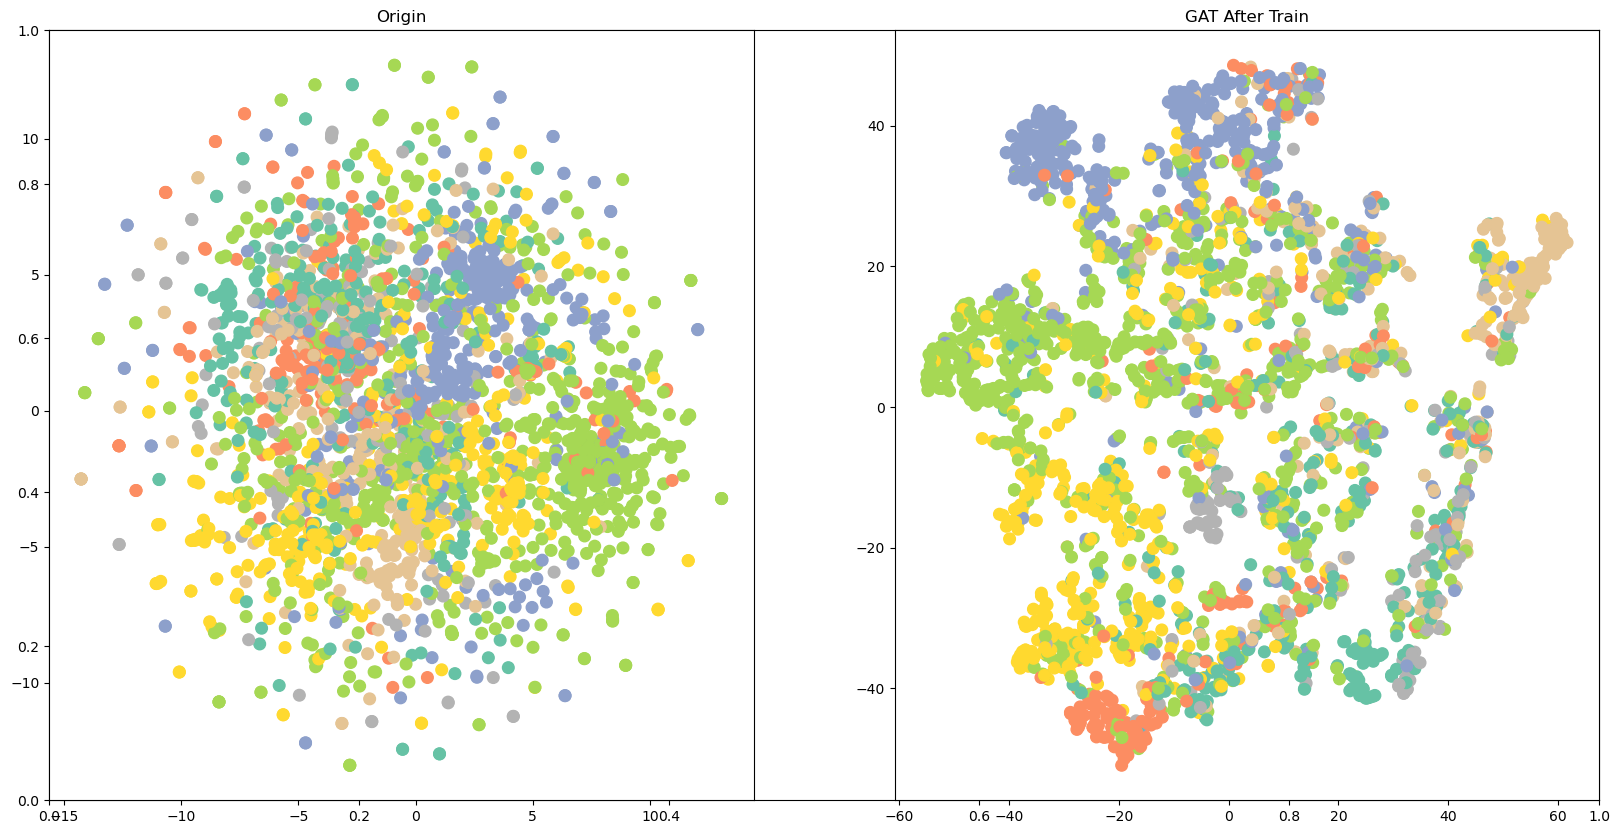

In [156]:
# 分类结果可视化
plt.figure(2)
fig, ax1 = plt.subplots(figsize=(20, 10))
plt.subplot(1, 2, 1)
visualize_two(data.x, color=data.y) # 原始数据的可视化
plt.title("Origin")
plt.subplot(1, 2, 2)
visualize_two(out, color=data.y) # GAT分类结果可视化
plt.title("GAT After Train")
plt.show()